# Hurricane Track Prediction - Visualization Suite

Comprehensive visualizations for the Kalman Filter hurricane track prediction project.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
FIG_SIZE = (10, 6)
DPI = 300
SAVE_DIR = 'figures/'

import os
os.makedirs(SAVE_DIR, exist_ok=True)


In [4]:
# Load processed dataset
df = pd.read_pickle("data/hurricane_paths_processed.pkl")
df = df.sort_values(['sid', 'iso_time']).reset_index(drop=True)

print(f"Loaded {len(df):,} observations from {df['sid'].nunique():,} storms")


Loaded 721,960 observations from 13,450 storms


## SECTION 1 — Problem Description

### Figure 1 — Example Hurricane Track (Truth Only)


ValueError: Can only compare identically-labeled Series objects

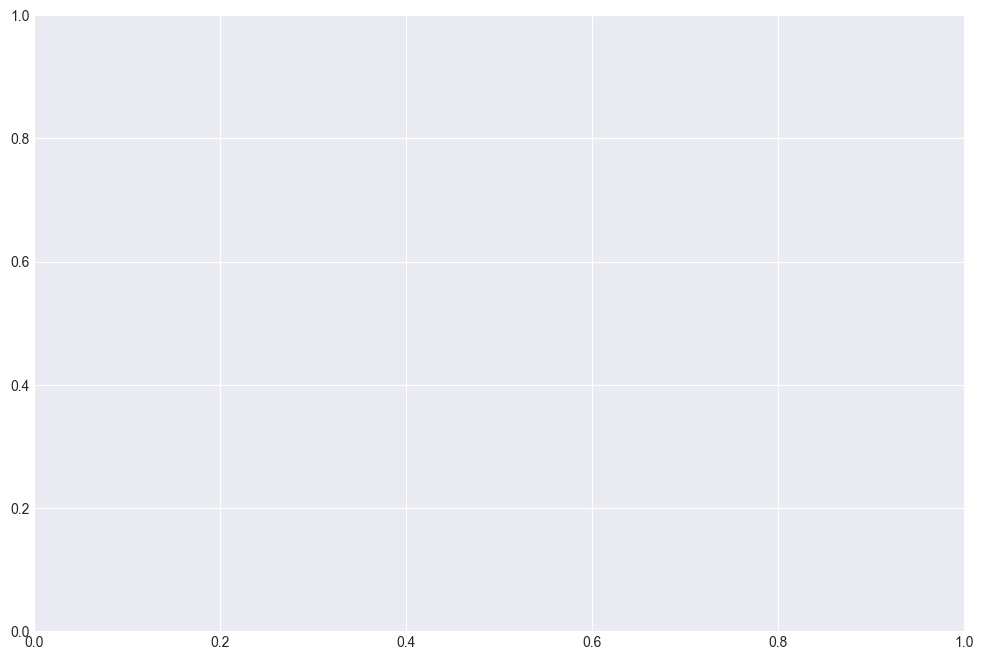

In [5]:
def plot_example_tracks(df, n_storms=2, save_path=None):
    """Plot example hurricane tracks showing curvature, recurvature, and land interaction"""
    
    # Select storms with interesting features
    # Look for storms with high curvature, recurvature, or land interaction
    if 'track_curvature' in df.columns:
        storm_stats = df.groupby('sid').agg({
            'track_curvature': lambda x: x.abs().max() if not x.isna().all() else 0,
            'is_approaching_land': 'sum' if 'is_approaching_land' in df.columns else lambda x: 0,
            'lat': ['min', 'max'],
            'lon': ['min', 'max'],
            'iso_time': 'count'
        }).reset_index()
    else:
        storm_stats = df.groupby('sid').agg({
            'lat': ['min', 'max'],
            'lon': ['min', 'max'],
            'iso_time': 'count'
        }).reset_index()
        storm_stats[('track_curvature', '<lambda>')] = 0
        storm_stats[('is_approaching_land', 'sum')] = 0
    
    # Filter to storms with sufficient observations
    storm_stats = storm_stats[storm_stats[('iso_time', 'count')] >= 10]
    
    # Select diverse storms
    if len(storm_stats) >= n_storms:
        # One with high curvature, one with land interaction
        selected = storm_stats.nlargest(n_storms, ('iso_time', 'count'))
    else:
        selected = storm_stats.head(n_storms)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = plt.cm.Set2(np.linspace(0, 1, n_storms))
    
    for idx, (_, storm_info) in enumerate(selected.iterrows()):
        sid = storm_info['sid']
        storm_data = df[df['sid'] == sid].sort_values('iso_time')
        
        # Plot track
        ax.plot(storm_data['lon'], storm_data['lat'], 
                linewidth=2, alpha=0.7, color=colors[idx], label=f'Storm {sid[:8]}')
        
        # Mark start and end
        ax.scatter(storm_data['lon'].iloc[0], storm_data['lat'].iloc[0], 
                  s=100, color=colors[idx], marker='o', edgecolors='black', linewidths=2, zorder=5)
        ax.scatter(storm_data['lon'].iloc[-1], storm_data['lat'].iloc[-1], 
                  s=100, color=colors[idx], marker='s', edgecolors='black', linewidths=2, zorder=5)
        
        # Add arrows to show direction
        n_arrows = min(5, len(storm_data) - 1)
        arrow_indices = np.linspace(0, len(storm_data) - 2, n_arrows, dtype=int)
        for i in arrow_indices:
            dx = storm_data['lon'].iloc[i+1] - storm_data['lon'].iloc[i]
            dy = storm_data['lat'].iloc[i+1] - storm_data['lat'].iloc[i]
            ax.arrow(storm_data['lon'].iloc[i], storm_data['lat'].iloc[i], 
                    dx*0.3, dy*0.3, head_width=0.5, head_length=0.3, 
                    fc=colors[idx], ec='black', alpha=0.7, zorder=4)
    
    # Add land/coastline context (simple approximation)
    # Draw approximate land masses
    ax.axhline(y=25, xmin=0.1, xmax=0.9, color='tan', alpha=0.3, linewidth=3, label='Land (approx)')
    
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    ax.set_title('Example Hurricane Tracks: Curvature, Recurvature, and Land Interaction', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

plot_example_tracks(df, n_storms=2, save_path=f'{SAVE_DIR}fig1_example_tracks.png')


### Figure 2 — KF Modeling Diagram


TypeError: FancyArrowPatch.__init__() takes from 1 to 3 positional arguments but 4 positional arguments (and 3 keyword-only arguments) were given

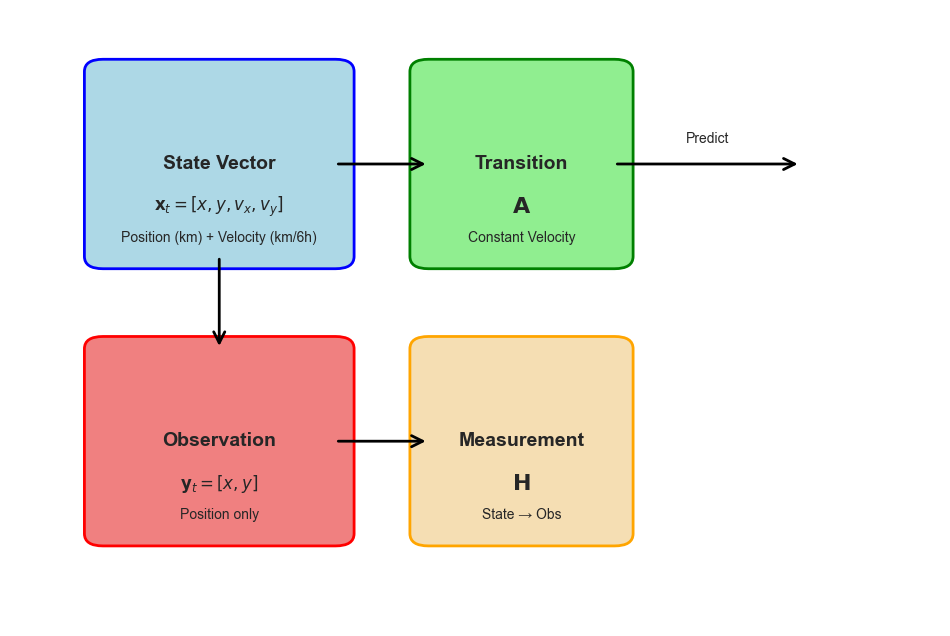

In [6]:
def plot_kf_diagram(save_path=None):
    """Create schematic diagram of Kalman Filter state-space model"""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    
    # State vector box
    state_box = FancyBboxPatch((0.1, 0.6), 0.25, 0.3, 
                               boxstyle="round,pad=0.02", 
                               edgecolor='blue', facecolor='lightblue', 
                               linewidth=2, transform=ax.transAxes)
    ax.add_patch(state_box)
    ax.text(0.225, 0.75, 'State Vector', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.225, 0.68, r'$\mathbf{x}_t = [x, y, v_x, v_y]$', ha='center', va='center', 
            fontsize=12, transform=ax.transAxes)
    ax.text(0.225, 0.63, 'Position (km) + Velocity (km/6h)', ha='center', va='center', 
            fontsize=10, transform=ax.transAxes)
    
    # Transition matrix
    trans_box = FancyBboxPatch((0.45, 0.6), 0.2, 0.3, 
                               boxstyle="round,pad=0.02", 
                               edgecolor='green', facecolor='lightgreen', 
                               linewidth=2, transform=ax.transAxes)
    ax.add_patch(trans_box)
    ax.text(0.55, 0.75, 'Transition', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.55, 0.68, r'$\mathbf{A}$', ha='center', va='center', 
            fontsize=16, transform=ax.transAxes)
    ax.text(0.55, 0.63, 'Constant Velocity', ha='center', va='center', 
            fontsize=10, transform=ax.transAxes)
    
    # Observation box
    obs_box = FancyBboxPatch((0.1, 0.15), 0.25, 0.3, 
                             boxstyle="round,pad=0.02", 
                             edgecolor='red', facecolor='lightcoral', 
                             linewidth=2, transform=ax.transAxes)
    ax.add_patch(obs_box)
    ax.text(0.225, 0.3, 'Observation', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.225, 0.23, r'$\mathbf{y}_t = [x, y]$', ha='center', va='center', 
            fontsize=12, transform=ax.transAxes)
    ax.text(0.225, 0.18, 'Position only', ha='center', va='center', 
            fontsize=10, transform=ax.transAxes)
    
    # Observation matrix
    H_box = FancyBboxPatch((0.45, 0.15), 0.2, 0.3, 
                           boxstyle="round,pad=0.02", 
                           edgecolor='orange', facecolor='wheat', 
                           linewidth=2, transform=ax.transAxes)
    ax.add_patch(H_box)
    ax.text(0.55, 0.3, 'Measurement', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.55, 0.23, r'$\mathbf{H}$', ha='center', va='center', 
            fontsize=16, transform=ax.transAxes)
    ax.text(0.55, 0.18, 'State → Obs', ha='center', va='center', 
            fontsize=10, transform=ax.transAxes)
    
    # Arrows
    # State to transition
    arrow1 = mpatches.FancyArrowPatch((0.35, 0.75), (0.45, 0.75), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes)
    ax.add_patch(arrow1)
    
    # Transition back to state (predict)
    arrow2 = mpatches.FancyArrowPatch((0.65, 0.75), (0.85, 0.75), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes)
    ax.add_patch(arrow2)
    ax.text(0.75, 0.78, 'Predict', ha='center', va='bottom', 
            fontsize=10, transform=ax.transAxes)
    
    # State to observation
    arrow3 = mpatches.FancyArrowPatch((0.225, 0.6), (0.225, 0.45), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes)
    ax.add_patch(arrow3)
    
    # Observation to H
    arrow4 = mpatches.FancyArrowPatch((0.35, 0.3), (0.45, 0.3), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes)
    ax.add_patch(arrow4)
    
    # H to state (update)
    arrow5 = mpatches.FancyArrowPatch((0.65, 0.3), (0.85, 0.3), (0.85, 0.6), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes, 
                                      connectionstyle="arc3,rad=0.3")
    ax.add_patch(arrow5)
    ax.text(0.9, 0.45, 'Update', ha='left', va='center', 
            fontsize=10, transform=ax.transAxes, rotation=-45)
    
    # Next state
    next_box = FancyBboxPatch((0.75, 0.6), 0.15, 0.3, 
                              boxstyle="round,pad=0.02", 
                              edgecolor='purple', facecolor='lavender', 
                              linewidth=2, transform=ax.transAxes)
    ax.add_patch(next_box)
    ax.text(0.825, 0.75, r'$\mathbf{x}_{t+1}$', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    
    ax.set_title('Kalman Filter State-Space Model', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

plot_kf_diagram(save_path=f'{SAVE_DIR}fig2_kf_diagram.png')


## SECTION 2 — Data Sourcing & Processing

### Figure 3 — Dataset Storm Density Map


Saved: figures/fig3_storm_density.png


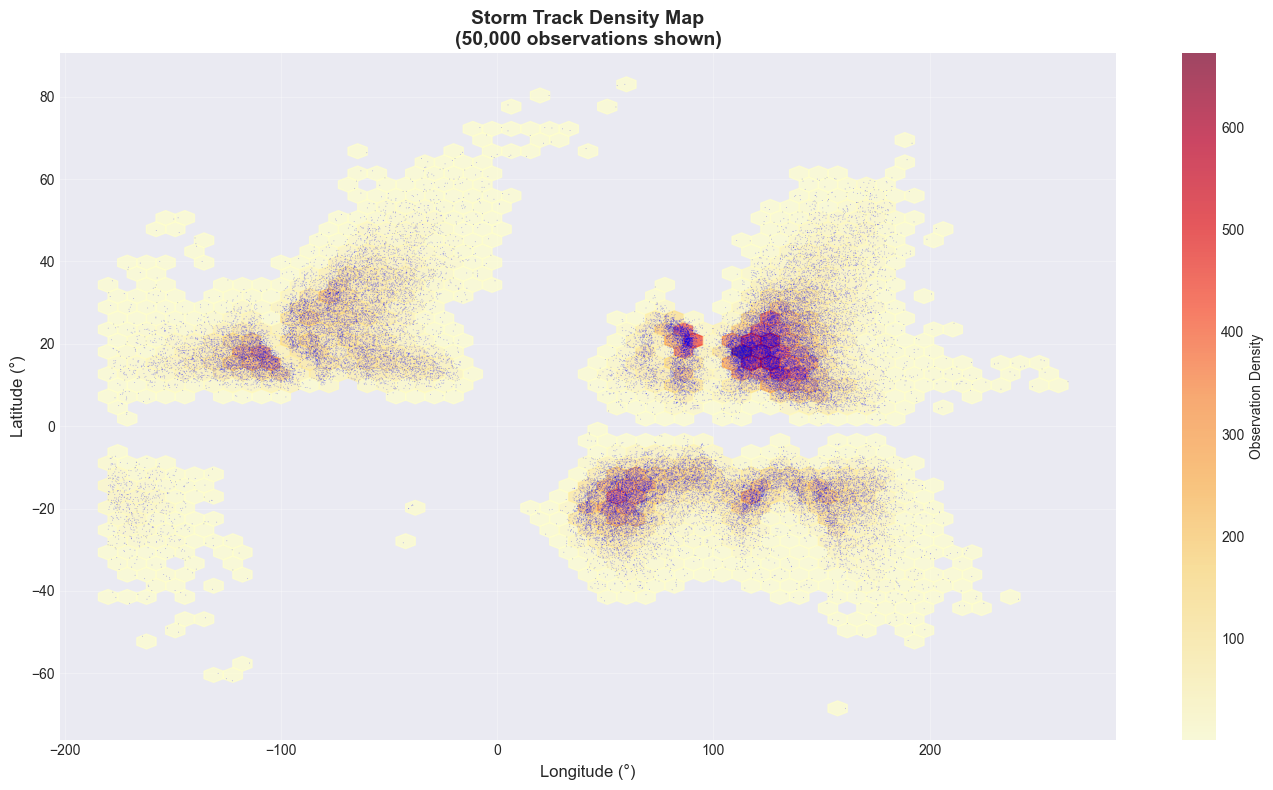

In [7]:
def plot_storm_density_map(df, save_path=None, sample_size=50000):
    """Plot spatial distribution of all storm track points"""
    
    # Sample if dataset is too large
    if len(df) > sample_size:
        df_plot = df.sample(n=sample_size, random_state=42)
    else:
        df_plot = df.copy()
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Create 2D histogram
    hb = ax.hexbin(df_plot['lon'], df_plot['lat'], gridsize=50, 
                   cmap='YlOrRd', mincnt=1, alpha=0.7)
    
    # Also overlay scatter for sparser regions
    ax.scatter(df_plot['lon'], df_plot['lat'], 
              s=0.5, alpha=0.3, c='blue', edgecolors='none')
    
    # Add colorbar
    cb = plt.colorbar(hb, ax=ax, label='Observation Density')
    
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    ax.set_title(f'Storm Track Density Map\n({len(df_plot):,} observations shown)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

plot_storm_density_map(df, save_path=f'{SAVE_DIR}fig3_storm_density.png')


### Figure 4 — Curvature Histogram


Saved: figures/fig4_curvature_histogram.png


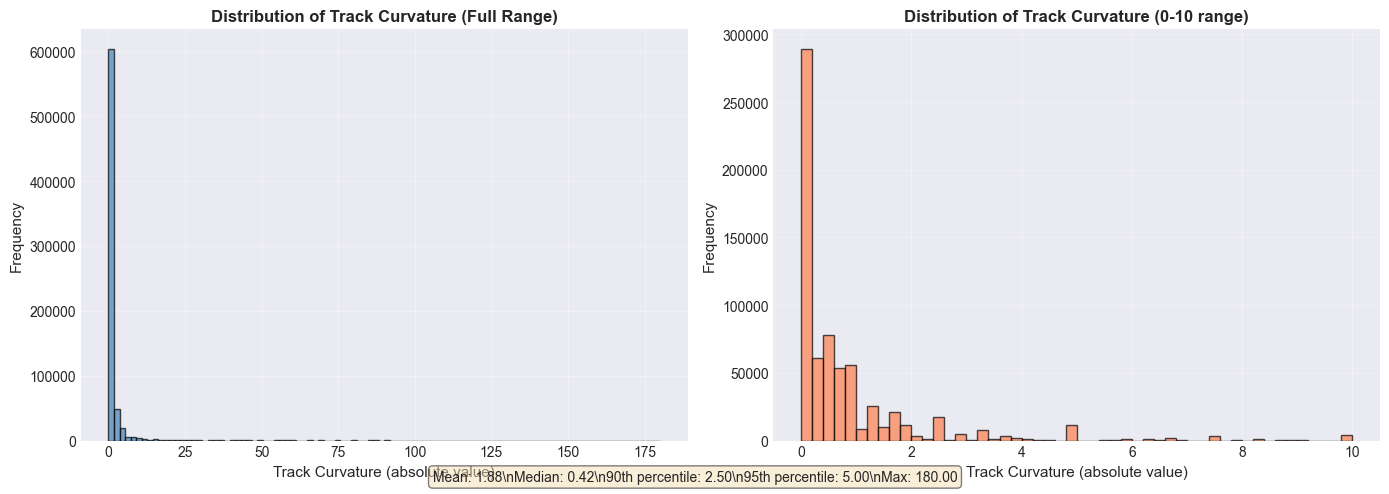

In [8]:
def plot_curvature_histogram(df, save_path=None):
    """Plot distribution of track curvature values"""
    
    if 'track_curvature' not in df.columns:
        print("Warning: track_curvature not found in dataset")
        return
    
    curvature = df['track_curvature'].dropna().abs()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Full histogram
    ax1.hist(curvature, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.set_xlabel('Track Curvature (absolute value)', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Distribution of Track Curvature (Full Range)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Zoomed in (0-10 range)
    curvature_clipped = curvature[curvature <= 10]
    ax2.hist(curvature_clipped, bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.set_xlabel('Track Curvature (absolute value)', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title('Distribution of Track Curvature (0-10 range)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics
    stats_text = f"Mean: {curvature.mean():.2f}\\nMedian: {curvature.median():.2f}\\n"
    stats_text += f"90th percentile: {curvature.quantile(0.9):.2f}\\n"
    stats_text += f"95th percentile: {curvature.quantile(0.95):.2f}\\n"
    stats_text += f"Max: {curvature.max():.2f}"
    
    fig.text(0.5, 0.02, stats_text, ha='center', va='bottom', 
             fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

plot_curvature_histogram(df, save_path=f'{SAVE_DIR}fig4_curvature_histogram.png')


### Figure 5 — Land Interaction Flag Over Time


Saved: figures/fig5_land_interaction.png


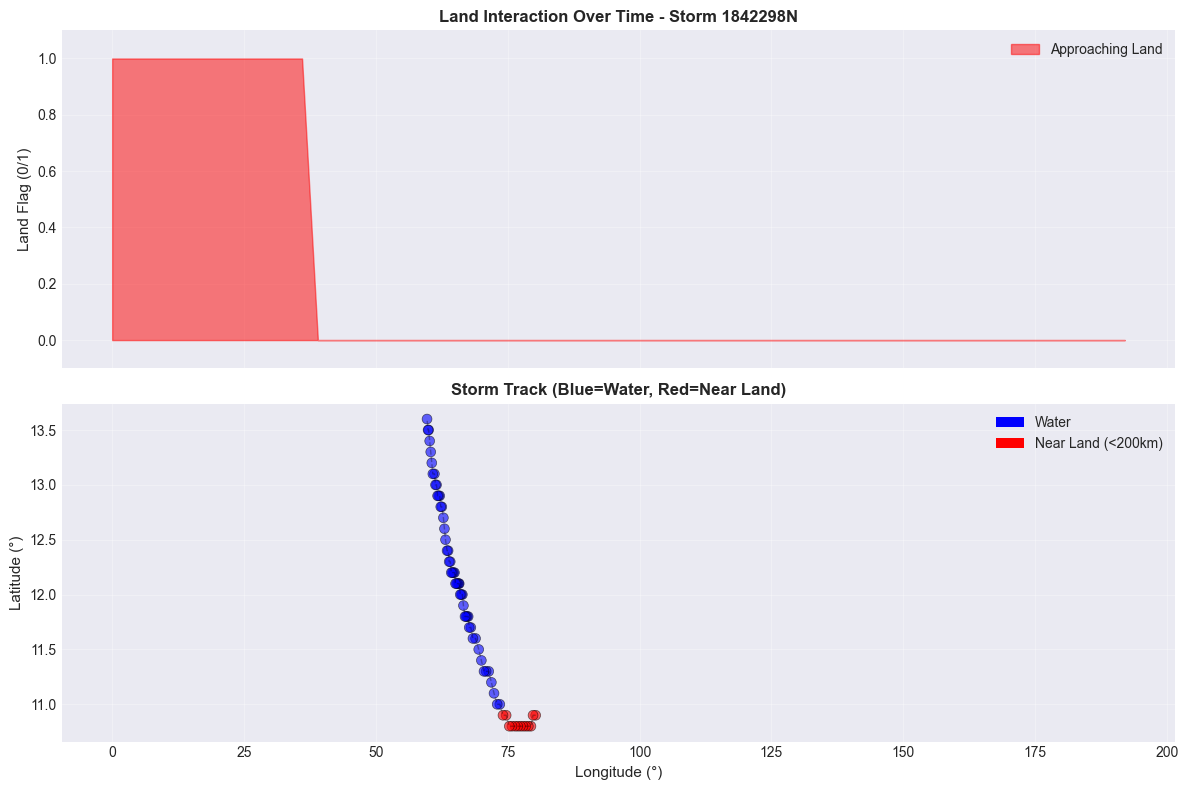

In [9]:
def plot_land_interaction_timeline(df, save_path=None):
    """Plot land interaction flag over time for a representative storm"""
    
    if 'is_approaching_land' not in df.columns:
        print("Warning: is_approaching_land not found in dataset")
        return
    
    # Find a storm with land interaction
    storm_land = df.groupby('sid')['is_approaching_land'].sum()
    storms_with_land = storm_land[storm_land > 0].index
    
    if len(storms_with_land) == 0:
        print("No storms with land interaction found")
        return
    
    # Select a storm with moderate land interaction
    selected_sid = storms_with_land[0]
    storm_data = df[df['sid'] == selected_sid].sort_values('iso_time')
    
    # Create time index (hours from start)
    time_hours = (storm_data['iso_time'] - storm_data['iso_time'].iloc[0]).dt.total_seconds() / 3600
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot 1: Land flag over time
    ax1.fill_between(time_hours, 0, storm_data['is_approaching_land'], 
                     alpha=0.5, color='red', label='Approaching Land')
    ax1.set_ylabel('Land Flag (0/1)', fontsize=11)
    ax1.set_title(f'Land Interaction Over Time - Storm {selected_sid[:8]}', 
                 fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-0.1, 1.1)
    
    # Plot 2: Track with land flag coloring
    colors = ['blue' if flag == 0 else 'red' for flag in storm_data['is_approaching_land']]
    ax2.scatter(storm_data['lon'], storm_data['lat'], c=colors, 
               s=50, alpha=0.6, edgecolors='black', linewidths=0.5)
    ax2.plot(storm_data['lon'], storm_data['lat'], 'k--', alpha=0.3, linewidth=1)
    ax2.set_xlabel('Longitude (°)', fontsize=11)
    ax2.set_ylabel('Latitude (°)', fontsize=11)
    ax2.set_title('Storm Track (Blue=Water, Red=Near Land)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', label='Water'),
                      Patch(facecolor='red', label='Near Land (<200km)')]
    ax2.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

plot_land_interaction_timeline(df, save_path=f'{SAVE_DIR}fig5_land_interaction.png')


## SECTION 3 — Modeling & Inference

**Note:** The following figures require running the Kalman Filter evaluation first. 
Make sure you have:
- KF filtering results (from `run_kalman_filter_on_storm`)
- Open-loop forecast results (from `open_loop_forecast_improved`)
- Innovation data (from `collect_innovation_data`)

### Figure 6 — Illustration of KF Filtering Over One Storm


In [10]:
# NOTE: This function requires KF results from Kalman_Filter.ipynb
# Run the KF evaluation cells first, then load results here

def plot_kf_filtering_illustration(storm_data, kf_results=None, save_path=None):
    """
    Plot KF filtering illustration showing state smoothing and velocity estimates
    
    Args:
        storm_data: DataFrame with storm observations
        kf_results: Dictionary with 'filtered_states', 'predictions', 'observations' 
                   (from run_kalman_filter_on_storm)
        save_path: Path to save figure
    """
    
    if kf_results is None:
        print("Note: kf_results not provided. This figure requires running KF first.")
        print("Please run the Kalman Filter evaluation in Kalman_Filter.ipynb")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Get data
    obs = kf_results.get('observations', [])
    filtered = kf_results.get('filtered_states', [])
    preds = kf_results.get('predictions', [])
    
    if len(obs) == 0 or len(filtered) == 0:
        print("Error: Missing required data in kf_results")
        return
    
    # Convert to arrays
    obs = np.array(obs)
    filtered = np.array(filtered)
    
    # Plot 1: State estimate smoothing (position)
    time_steps = np.arange(len(obs))
    
    ax1.plot(time_steps, obs[:, 0], 'ro', markersize=4, alpha=0.6, label='Raw Observations (x)')
    ax1.plot(time_steps, obs[:, 1], 'bo', markersize=4, alpha=0.6, label='Raw Observations (y)')
    ax1.plot(time_steps, filtered[:, 0], 'r-', linewidth=2, label='Filtered Estimate (x)')
    ax1.plot(time_steps, filtered[:, 1], 'b-', linewidth=2, label='Filtered Estimate (y)')
    
    ax1.set_xlabel('Time Step', fontsize=11)
    ax1.set_ylabel('Position (km)', fontsize=11)
    ax1.set_title('State Estimate Smoothing: Truth vs Observations vs Filtered', 
                 fontsize=12, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Velocity estimates
    if filtered.shape[1] >= 4:
        ax2.plot(time_steps, filtered[:, 2], 'g-', linewidth=2, label='Velocity X (km/6h)')
        ax2.plot(time_steps, filtered[:, 3], 'm-', linewidth=2, label='Velocity Y (km/6h)')
        ax2.set_xlabel('Time Step', fontsize=11)
        ax2.set_ylabel('Velocity (km/6h)', fontsize=11)
        ax2.set_title('Estimated Velocities Over Time', fontsize=12, fontweight='bold')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example usage (uncomment after running KF):
# plot_kf_filtering_illustration(storm_data, kf_results, save_path=f'{SAVE_DIR}fig6_kf_filtering.png')


### Figure 7 — KF Prediction vs Update Cycle (One Step)


Saved: figures/fig7_kf_cycle.png


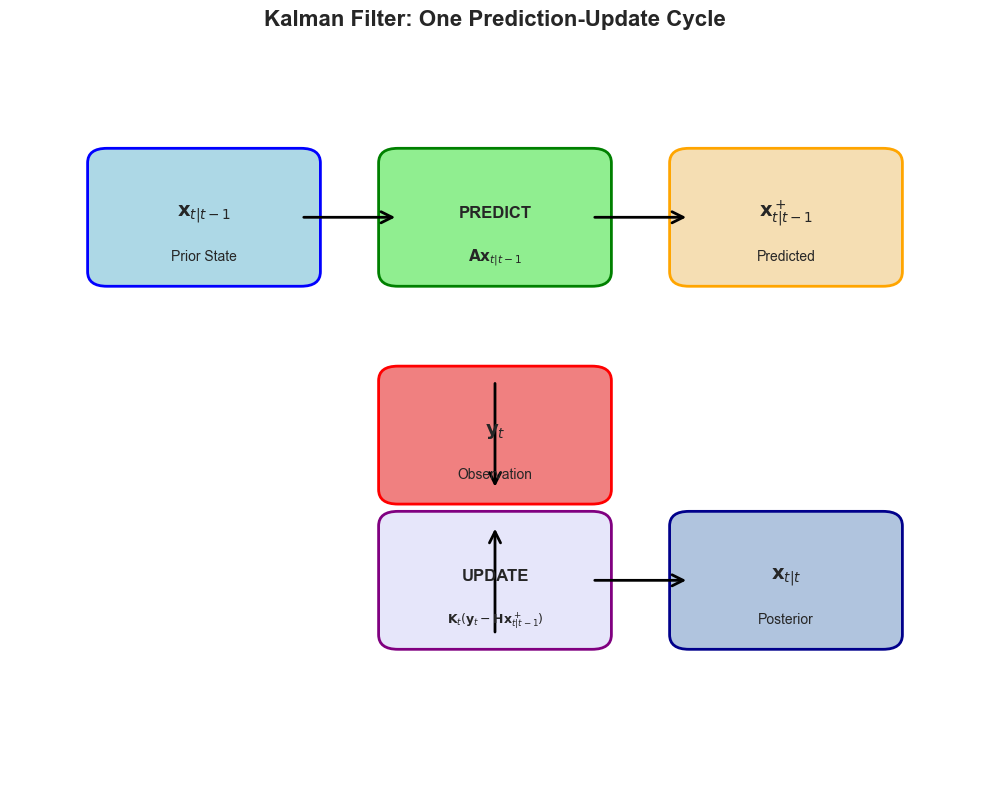

In [11]:
def plot_kf_cycle_diagram(save_path=None):
    """Visual diagram of one KF prediction-update cycle"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')
    
    # Step 1: Prior state
    prior_box = FancyBboxPatch((0.1, 0.7), 0.2, 0.15, 
                               boxstyle="round,pad=0.02", 
                               edgecolor='blue', facecolor='lightblue', 
                               linewidth=2, transform=ax.transAxes)
    ax.add_patch(prior_box)
    ax.text(0.2, 0.78, r'$\mathbf{x}_{t|t-1}$', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.2, 0.72, 'Prior State', ha='center', va='center', 
            fontsize=10, transform=ax.transAxes)
    
    # Step 2: Prediction
    pred_box = FancyBboxPatch((0.4, 0.7), 0.2, 0.15, 
                             boxstyle="round,pad=0.02", 
                             edgecolor='green', facecolor='lightgreen', 
                             linewidth=2, transform=ax.transAxes)
    ax.add_patch(pred_box)
    ax.text(0.5, 0.78, 'PREDICT', ha='center', va='center', 
            fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.72, r'$\mathbf{A} \mathbf{x}_{t|t-1}$', ha='center', va='center', 
            fontsize=11, transform=ax.transAxes)
    
    # Step 3: Predicted state
    pred_state_box = FancyBboxPatch((0.7, 0.7), 0.2, 0.15, 
                                   boxstyle="round,pad=0.02", 
                                   edgecolor='orange', facecolor='wheat', 
                                   linewidth=2, transform=ax.transAxes)
    ax.add_patch(pred_state_box)
    ax.text(0.8, 0.78, r'$\mathbf{x}_{t|t-1}^+$', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.8, 0.72, 'Predicted', ha='center', va='center', 
            fontsize=10, transform=ax.transAxes)
    
    # Observation
    obs_box = FancyBboxPatch((0.4, 0.4), 0.2, 0.15, 
                            boxstyle="round,pad=0.02", 
                            edgecolor='red', facecolor='lightcoral', 
                            linewidth=2, transform=ax.transAxes)
    ax.add_patch(obs_box)
    ax.text(0.5, 0.48, r'$\mathbf{y}_t$', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.42, 'Observation', ha='center', va='center', 
            fontsize=10, transform=ax.transAxes)
    
    # Step 4: Update
    update_box = FancyBboxPatch((0.4, 0.2), 0.2, 0.15, 
                               boxstyle="round,pad=0.02", 
                               edgecolor='purple', facecolor='lavender', 
                               linewidth=2, transform=ax.transAxes)
    ax.add_patch(update_box)
    ax.text(0.5, 0.28, 'UPDATE', ha='center', va='center', 
            fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.22, r'$\mathbf{K}_t (\mathbf{y}_t - \mathbf{H}\mathbf{x}_{t|t-1}^+)$', 
            ha='center', va='center', fontsize=9, transform=ax.transAxes)
    
    # Step 5: Posterior state
    post_box = FancyBboxPatch((0.7, 0.2), 0.2, 0.15, 
                             boxstyle="round,pad=0.02", 
                             edgecolor='darkblue', facecolor='lightsteelblue', 
                             linewidth=2, transform=ax.transAxes)
    ax.add_patch(post_box)
    ax.text(0.8, 0.28, r'$\mathbf{x}_{t|t}$', ha='center', va='center', 
            fontsize=14, fontweight='bold', transform=ax.transAxes)
    ax.text(0.8, 0.22, 'Posterior', ha='center', va='center', 
            fontsize=10, transform=ax.transAxes)
    
    # Arrows
    arrow1 = mpatches.FancyArrowPatch((0.3, 0.775), (0.4, 0.775), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes)
    ax.add_patch(arrow1)
    
    arrow2 = mpatches.FancyArrowPatch((0.6, 0.775), (0.7, 0.775), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes)
    ax.add_patch(arrow2)
    
    arrow3 = mpatches.FancyArrowPatch((0.5, 0.55), (0.5, 0.4), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes)
    ax.add_patch(arrow3)
    
    arrow4 = mpatches.FancyArrowPatch((0.5, 0.2), (0.5, 0.35), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes)
    ax.add_patch(arrow4)
    
    arrow5 = mpatches.FancyArrowPatch((0.6, 0.275), (0.7, 0.275), 
                                      arrowstyle='->', mutation_scale=20, 
                                      linewidth=2, color='black', transform=ax.transAxes)
    ax.add_patch(arrow5)
    
    ax.set_title('Kalman Filter: One Prediction-Update Cycle', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

plot_kf_cycle_diagram(save_path=f'{SAVE_DIR}fig7_kf_cycle.png')


## SECTION 4 — Results & Discussion

**CRITICAL:** These figures require KF evaluation results. Run the evaluation cells in `Kalman_Filter.ipynb` first.

### Figure 8 — Forecast Error vs Lead Time (CRITICAL)


In [12]:
def plot_forecast_error_vs_leadtime(rmse_results_baseline=None, rmse_results_adaptive=None, 
                                     save_path=None):
    """
    Plot RMSE vs lead time for baseline and adaptive KF models
    
    Args:
        rmse_results_baseline: Dict or DataFrame with lead times and RMSE values
                              Format: {'lead_times': [6, 12, 24, 48, 72], 'rmse': [15.86, 34.50, ...]}
        rmse_results_adaptive: Same format for adaptive model
        save_path: Path to save figure
    """
    
    # Default example data (replace with actual results)
    if rmse_results_baseline is None:
        print("Using example data. Replace with actual results from KF evaluation.")
        rmse_results_baseline = {
            'lead_times': [6, 12, 24, 48, 72],
            'rmse': [15.86, 34.50, 83.79, 216.74, 379.35]
        }
    
    if rmse_results_adaptive is None:
        rmse_results_adaptive = rmse_results_baseline.copy()  # Same for now
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract data
    if isinstance(rmse_results_baseline, dict):
        lead_times = rmse_results_baseline['lead_times']
        rmse_baseline = rmse_results_baseline['rmse']
    else:
        # Assume DataFrame
        lead_times = rmse_results_baseline.index if hasattr(rmse_results_baseline, 'index') else range(len(rmse_results_baseline))
        rmse_baseline = rmse_results_baseline.values if hasattr(rmse_results_baseline, 'values') else rmse_results_baseline
    
    if isinstance(rmse_results_adaptive, dict):
        rmse_adaptive = rmse_results_adaptive['rmse']
    else:
        rmse_adaptive = rmse_results_adaptive.values if hasattr(rmse_results_adaptive, 'values') else rmse_results_adaptive
    
    # Plot
    ax.plot(lead_times, rmse_baseline, 'o-', linewidth=2, markersize=8, 
           label='Base KF', color='blue')
    ax.plot(lead_times, rmse_adaptive, 's-', linewidth=2, markersize=8, 
           label='Adaptive-Q KF', color='red', linestyle='--')
    
    ax.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
    ax.set_ylabel('RMSE (km)', fontsize=12)
    ax.set_title('Forecast Error vs Lead Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (lt, rmse) in enumerate(zip(lead_times, rmse_baseline)):
        ax.annotate(f'{rmse:.1f}', (lt, rmse), textcoords="offset points", 
                   xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example usage (replace with actual results):
# plot_forecast_error_vs_leadtime(rmse_baseline, rmse_adaptive, save_path=f'{SAVE_DIR}fig8_forecast_error.png')
